In [1]:
import torch
import timm
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torch.nn import *
from csvlogger import CSVLogger
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os

In [2]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
       
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 11.8
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 3060 Laptop GPU


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Device: {device}")

Device: cuda


In [4]:
print(os.listdir('Binary_ttv\\src')) # Preliminary Image Processing\Alzheimer_s Dataset_binary\src
print(os.listdir('Binary_ttv\\train'))
print(os.listdir('Binary_ttv\\test'))
print(os.listdir('Binary_ttv\\val'))

['Demented', 'NonDemented']
['Demented', 'NonDemented']
['Demented', 'NonDemented']
['Demented', 'NonDemented']


In [5]:
# Define transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((176, 208)),  # Resize images to a common size (adjust as needed)
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # Normalize using ImageNet stats
])

# Load training and testing datasets
train_dataset = ImageFolder(root='Binary_ttv\\train', transform=transform)
test_dataset = ImageFolder(root='Binary_ttv\\test', transform=transform)
val_dataset = ImageFolder(root='Binary_ttv\\val', transform=transform)

batch_size = 26  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

print(len(train_loader))
print(len(test_loader))
print(len(val_loader))
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

3661
776
499
95165
20170
12967


In [6]:
learning_rate = 0.0001
epochs = 50
patience = 5

Model architecture definition


In [7]:
model = Sequential(
    # Convolutional layers
    Conv2d(3, 32, kernel_size=3, padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2),
    
    Conv2d(32, 32, kernel_size=3, padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2),
    
    # Fully connected layers
    Flatten(),
    Linear(32 * 44 * 52, 150),  # Adjust the input size based on your image dimensions
    ReLU(),
    Dropout(0.2),
    Linear(150, 1),  # Output layer with one neuron and sigmoid activation
    Sigmoid()
).to(device)

In [8]:
# Loss and optimizer
loss_value = BCELoss()  # Binary Cross Entropy Loss for binary classification
# loss_value = BCEWithLogitsLoss()  # Binary Cross Entropy with Logits Loss
model_opt = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

# Logging
losslogger = CSVLogger('custom_model_loss.csv', fieldnames=["datetime", "batch", "epoch", "train_loss", "val_loss", "val_accuracy"])
acclogger = CSVLogger('custom_model_acc.csv', fieldnames=["datetime", "average_accuracy"])

# Training loop
num_epochs = epochs
early_stopping = False
best_loss = float('inf')

print(f"Device: {device}")
print(f"Start time: {datetime.datetime.now()}")
counter = 0
track_epochs = 0

for epoch in range(num_epochs):
    model.train()
    print("Starting training loop...")
    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.float().to(device)
        model_opt.zero_grad()
        outputs = model(inputs)
        loss = loss_value(outputs, labels.unsqueeze(1))
        loss.backward()
        model_opt.step()
        counter += 1
        if counter % 1220 == 0:
            print(f"Completed {counter} batches at {datetime.datetime.now()}")

    # Validation
    model.eval()
    total = 0
    correct = 0
    val_loss = 0.0
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.float().to(device)
        val_outputs = model(val_inputs)
        val_loss += loss_value(val_outputs, val_labels.unsqueeze(1)).item()
        predicted = (val_outputs > 0.5).float()
        total += val_labels.size(0)
        correct += (predicted == val_labels.unsqueeze(1)).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    losslog_data = {"datetime": datetime.datetime.now(), "batch": batch_size, "epoch": epoch + 1, "train_loss": loss.item(), "val_loss": val_loss, "val_accuracy": val_accuracy}
    losslogger.log(losslog_data)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

        # If validation loss hasn't improved for 'patience' epochs, stop early
        if patience_counter >= patience:
            print("Early stopping triggered")
            early_stopping = True
            break

    if early_stopping:
        break

    print(f"Completed epoch {epoch + 1}, loss {loss.item()}, validation loss {val_loss}, validation accuracy {val_accuracy}, time {datetime.datetime.now()}")
    track_epochs += 1

# Testing
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.float().to(device)
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

# Testing
correct = 0
total = 0
model.eval()
all_predicted = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.float().to(device)
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


accuracy = 100 * correct / total
acclog_data = {"datetime": datetime.datetime.now(), "average_accuracy": accuracy}
acclogger.log(acclog_data)
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Save model
torch.save(model.state_dict(), 'Models/custom_model.pth')


Device: cuda
Start time: 2023-11-07 02:23:27.712552
Starting training loop...
Completed 1220 batches at 2023-11-07 02:25:19.885599
Completed 2440 batches at 2023-11-07 02:26:55.216235
Completed 3660 batches at 2023-11-07 02:28:27.455084
Completed epoch 1, loss 0.02051524631679058, validation loss 0.07580253485711964, validation accuracy 97.37795943549008, time 2023-11-07 02:29:19.638872
Starting training loop...
Completed 4880 batches at 2023-11-07 02:30:39.868832
Completed 6100 batches at 2023-11-07 02:32:01.962626
Completed 7320 batches at 2023-11-07 02:33:22.728545
Completed epoch 2, loss 0.0014324255753308535, validation loss 0.014326640335506728, validation accuracy 99.68381275545616, time 2023-11-07 02:34:02.377387
Starting training loop...
Completed 8540 batches at 2023-11-07 02:35:17.711509
Completed 9760 batches at 2023-11-07 02:36:33.510079
Completed 10980 batches at 2023-11-07 02:37:49.144272
Completed epoch 3, loss 3.294307316537015e-05, validation loss 0.004263754855879378

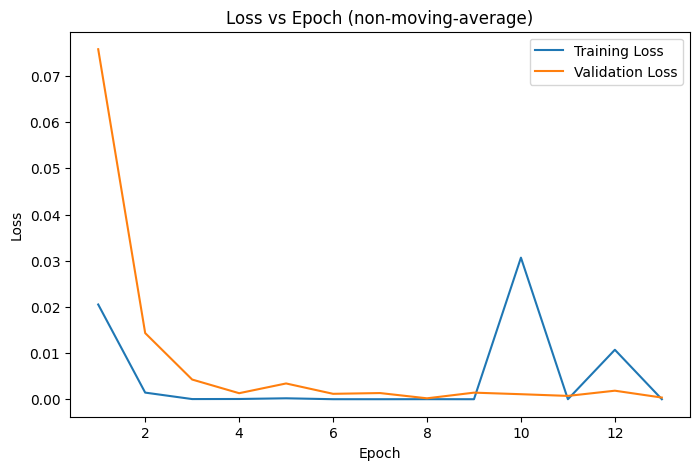

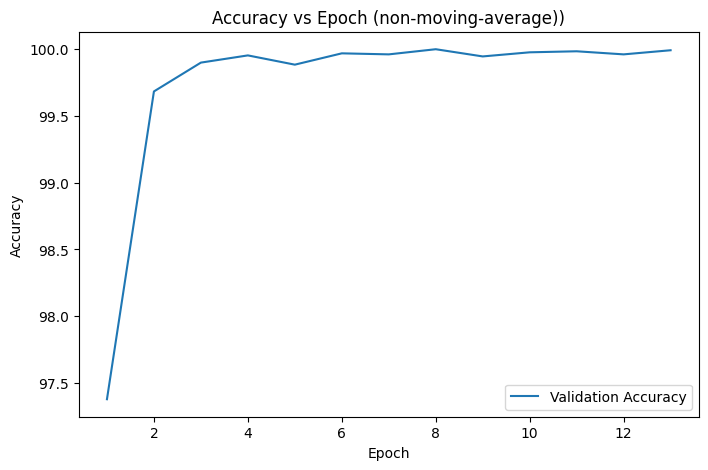

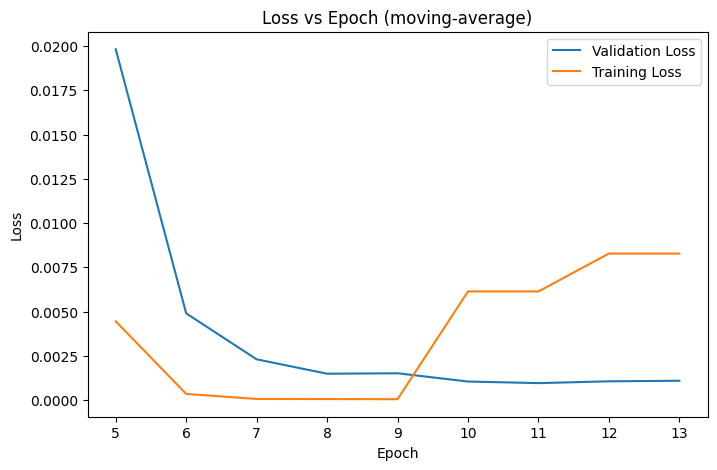

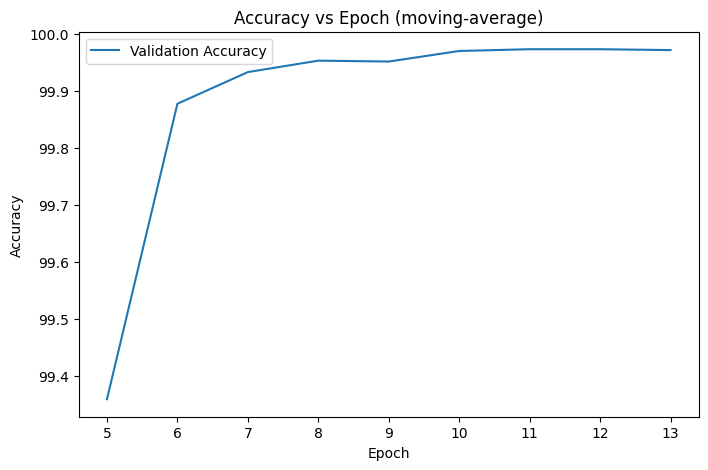

In [9]:
lossdf = pd.read_csv("custom_model_loss.csv", engine="pyarrow")
rolling_mean = lossdf["val_loss"].rolling(window=5).mean()
rolling_mean2 = lossdf["train_loss"].rolling(window=5).mean()
rolling_mean3 = lossdf["val_accuracy"].rolling(window=5).mean()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], lossdf["train_loss"], label="Training Loss")
plt.plot(lossdf["epoch"], lossdf["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch (non-moving-average)")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], lossdf["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch (non-moving-average))")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], rolling_mean, label="Validation Loss")
plt.plot(lossdf["epoch"], rolling_mean2, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch (moving-average)")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], rolling_mean3, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch (moving-average)")
plt.legend()
plt.show()




Accuracy on the test dataset: 99.965295%

Confusion Matrix:
 [[10080     7]
 [    0 10083]]


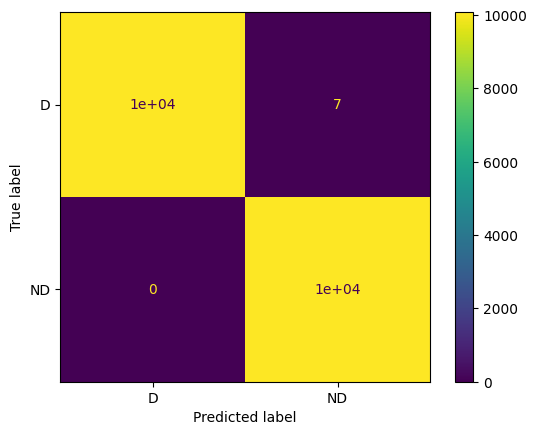


Manual Precision: 0.9993062438057483
Manual Recall: 1.0

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10087
         1.0       1.00      1.00      1.00     10083

    accuracy                           1.00     20170
   macro avg       1.00      1.00      1.00     20170
weighted avg       1.00      1.00      1.00     20170



AUC-ROC Score: 0.999653


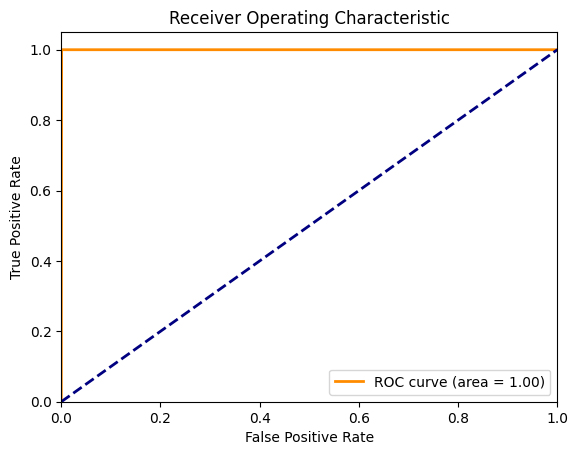

In [10]:
import torch
import timm
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve, roc_auc_score, precision_score, recall_score, ConfusionMatrixDisplay

accuracy = 100 * correct / total
acclog_data = {"datetime": datetime.datetime.now(), "average_accuracy": accuracy}
acclogger.log(acclog_data)
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Calculate the confusion matrix
confusion = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:\n", confusion)
cm = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=["D", "ND"])
cm.plot()
plt.show()
print(cm, end='\n\n')

# Generate precision-recall metrics
precision_manual = precision_score(all_labels, all_predicted)
recall_manual = recall_score(all_labels, all_predicted)

print("Manual Precision:", precision_manual)
print("Manual Recall:", recall_manual, end="\n\n")

# Generate classification report
report = classification_report(all_labels, all_predicted)
print("Classification Report:\n", report, end='\n\n')

# Calculate ROC curve and AUC-ROC score
# fpr, tpr, thresholds = roc_curve(all_labels, outputs.cpu().numpy()[:, 1].astype(float))
fpr, tpr, thresholds = roc_curve(y_true=all_labels, y_score=all_predicted)
roc_auc = auc(fpr, tpr)
print("\nAUC-ROC Score: {:.6f}".format(roc_auc))

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Bigger testing

In [13]:
model = Sequential(
    # Convolutional layers
    Conv2d(3, 32, kernel_size=3, padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2),
    
    Conv2d(32, 32, kernel_size=3, padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2),
    
    # Fully connected layers
    Flatten(),
    Linear(32 * 44 * 52, 150),  # Adjust the input size based on your image dimensions
    ReLU(),
    Dropout(0.2),
    Linear(150, 1),  # Output layer with one neuron and sigmoid activation
    Sigmoid()
).to(device)

In [14]:
# Define transformations for image preprocessing
transform2 = transforms.Compose([
    transforms.Resize((176, 208)),  # Resize images to a common size (adjust as needed)
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # Normalize using ImageNet stats
])

# Load training and testing datasets
# train_dataset = ImageFolder(root='Binary_ttv\\train', transform=transform2)
test_dataset = ImageFolder(root='NewBinary_TTV\\test', transform=transform2)
# val_dataset = ImageFolder(root='Binary_ttv\\val', transform=transform2)

batch_size = 26  # Adjust as needed
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
# val_loader = DataLoader(val_dataset, batch_size=batch_size)

# print(len(train_loader))
print(len(test_loader))
# print(len(val_loader))
# print(len(train_dataset))
print(len(test_dataset))
# print(len(val_dataset))

776
20166


In [15]:

# # Import the timm pth models
# model = torch.load("mobilenetv3_large.pth")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Load the saved state dictionary into the model
model.load_state_dict(torch.load('Models/custom_model.pth', map_location=device))

correct = 0
total = 0
all_predicted = []
all_labels = []
counter = 0

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        counter += 1
        if counter % 5000 == 0:
            print(f"Completed {counter} batches")

accuracy = 100 * correct / total

print("Done testing")



Device: cuda
Done testing




Accuracy on the test dataset: 50.000000%

Confusion Matrix:
 [[10083     0]
 [10083     0]]


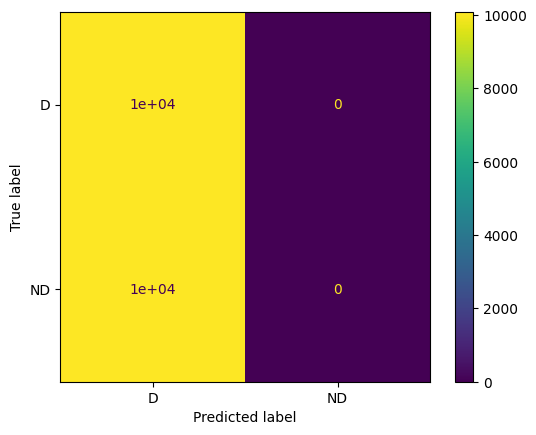


Manual Precision: 0.0
Manual Recall: 0.0

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67     10083
           1       0.00      0.00      0.00     10083

    accuracy                           0.50     20166
   macro avg       0.25      0.50      0.33     20166
weighted avg       0.25      0.50      0.33     20166



AUC-ROC Score: 0.500000


c:\Users\hifia\anaconda3\envs\DementiaGPU\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hifia\anaconda3\envs\DementiaGPU\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hifia\anaconda3\envs\DementiaGPU\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hifia\anaconda3\

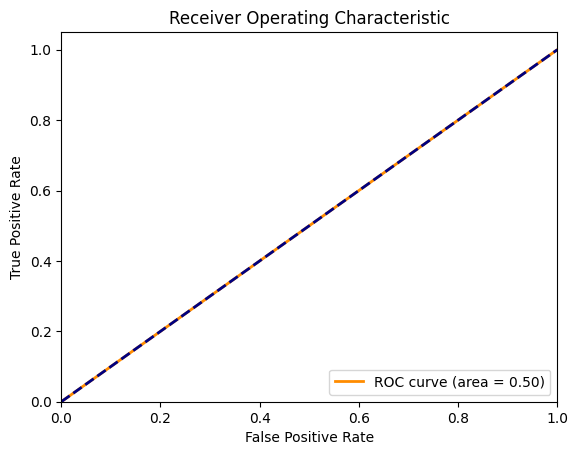

In [16]:
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Calculate the confusion matrix
confusion = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:\n", confusion)
cm = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=["D", "ND"])
cm.plot()
plt.show()
print(cm, end='\n\n')

# Generate precision-recall metrics
precision_manual = precision_score(all_labels, all_predicted)
recall_manual = recall_score(all_labels, all_predicted)

print("Manual Precision:", precision_manual)
print("Manual Recall:", recall_manual, end="\n\n")

# Generate classification report
report = classification_report(all_labels, all_predicted)
print("Classification Report:\n", report, end='\n\n')

# Calculate ROC curve and AUC-ROC score
# fpr, tpr, thresholds = roc_curve(all_labels, outputs.cpu().numpy()[:, 1].astype(float))
fpr, tpr, thresholds = roc_curve(y_true=all_labels, y_score=all_predicted)
roc_auc = auc(fpr, tpr)
print("\nAUC-ROC Score: {:.6f}".format(roc_auc))

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()